# Beyond frequency vectors



## Pre-preocessing

The first step is processing the data, as we did last time. The code below extracts the sentences for each subject. In addition, it removes the interviewer.

In [ ]:
%%capture
!rm -rf ObjectEllicitationNLP
!git clone https://github.com/yurisugano/ObjectEllicitationNLP.git
!pip install python-docx
!pip install -q -U spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.6.0/en_core_web_md-3.6.0.tar.gz

import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
# Load necessary packages
import re
from docx import Document

# Read the transcript from the cloud
raw_data = Document('/content/ObjectEllicitationNLP/Transcripts.docx')


# Define functions to handle formatting
def add_curly_braces(paragraph_text):
    """Add curly braces to three-digit numbers not surrounded by square brackets or curly braces."""
    numbers = re.findall(r'(?<![\[{])\b(\d{3})\b(?![\]}])', paragraph_text)
    for number in numbers:
        transformed_number = '{' + number + '}'
        paragraph_text = re.sub(r'\b' + number + r'\b', transformed_number, paragraph_text)
    return paragraph_text

def handle_square_brackets(paragraph_text):
    """Handle numbers inside square brackets with optional spaces and dashes."""
    matches = re.findall(r'\[([\d\s,-]+)\]', paragraph_text)
    for match in matches:
        numbers = []
        for num_range in re.split(r',\s*|\s+', match):
            num_range = num_range.strip()
            if '-' in num_range:
                start, end = num_range.split('-')
                numbers.extend(range(int(start), int(end) + 1))
            else:
                numbers.append(int(num_range))

        transformed = '[' + ']['.join(map(str, numbers)) + ']'
        paragraph_text = paragraph_text.replace('[' + match + ']', transformed)
    return paragraph_text

# Iterate over each paragraph
for each_paragraph in raw_data.paragraphs:
    each_paragraph.text = add_curly_braces(each_paragraph.text)
    each_paragraph.text = handle_square_brackets(each_paragraph.text)

def extract_info(paragraph_text):
    """Extract speaker, sentences, and objects from a paragraph text."""
    speaker_match = re.search(r'\{(\d{3})\}', paragraph_text)
    sentence_match = re.search(r': (.*)', paragraph_text)
    objects_match = re.findall(r'\[(\d{3})\]', paragraph_text)

    if speaker_match and sentence_match:
        speaker = speaker_match.group(1)
        sentence = sentence_match.group(1)
        objects = [int(object_id) for object_id in objects_match]
        return speaker, sentence, objects
    else:
        return None, None, None


def update_data(data, speaker, sentence, objects):
    """Update data dictionary with extracted speaker, sentence, and objects."""
    if speaker:
        if speaker in data:
            data[speaker]['statements'].append(sentence)
            data[speaker]['objects'].extend(objects)
        else:
            data[speaker] = {'subject': speaker, 'statements': [statement], 'objects': objects}

# Initialize an empty dictionary to store the data
data = {}

# Loop over each paragraph in the document
for each_paragraph in raw_data.paragraphs:
    speaker, statement, objects = extract_info(each_paragraph.text)
    update_data(data, speaker, statement, objects)

# Delete the interviewer
del data['000']

## Word2Vec

Vectorization aims to represent words in space. As we saw, vectorization with BoW is a straightforward way to represent word vectors. However, BoW does not capture meaning from context. As such, words are represented a space that has no meaningful characteristics.

We will use a more advanced technique called Word2Vec. Word2Vec captures meaning from context and thus provides vectors that are more informative. Words with similar meaning are represented close to each other in space. More accurately, semantic relationships between words are captured by the geometric relationships between their vectors.

We will use the package 'Spacy'. Spacy's `en_core_web_md` model is a Word2Vec model pre-trained in a large database of websites, capturing a wide variety of English words. More info on en_core_web_md [here](https://spacy.io/models/en).


---
ℹ️ In machine learning, using a pre-trained model in a novel context is called **transfer learning**. We will use transfer learning in most, if not all, parts of analysis.

---

In [ ]:
import spacy
import numpy as np

# Load Spacy's pre-trained model as w2v
w2v = spacy.load('en_core_web_md')

You can perform arithmetic on Word2Vec representations. The following is a canonical Word2Vec example showing that

"king" - "man" + "woman" = "queen"

This illustrates that the abstract representation of these words in space now carries meaning. We map king to a new region in space. On a surface, mapping is done by taking away all the features that represent "man" from the word "king", then adding all the features that represent "woman". The resulting representation is very close in space to the word "queen"


---
ℹ️ Distances in multi-dimensional vector spaces are commonly measured with **cosine similarity**. Words that have nothing in common to one another will have a cosine similarity close to zero. Two words that are close to each other in meaning will have a cosine similarity close to one.

---



In [ ]:
# Compute vectors for "king", "man", "woman", and "queen"
king = w2v('king').vector
man = w2v('man').vector
woman = w2v('woman').vector
queen = w2v('queen').vector

# Compute the result of "king - man + woman"
result = king - man + woman

# Compute the cosine similarity between the result and the vector for "queen"
similarity = np.dot(result, queen) / (np.linalg.norm(result) * np.linalg.norm(queen))
print(similarity)

# Compute the cosine similarity between result and a control word "lettuce"
lettuce = w2v('lettuce').vector
similarity = np.dot(result, lettuce) / (np.linalg.norm(result) * np.linalg.norm(lettuce))
print(similarity)

0.6178015
0.06811896


Let's construct a vector representation for all words in our data. Some words might not have a representation if they were not included on the original training dataset.

Starting with pre-processing, we will:

1.  [Tokenize](ttps://colab.research.google.com/drive/1KhWSaZ8PQgVelkrOFH1GqT4PPd5xRFqu#scrollTo=m4PlEXbJfXYh&line=1&uniqifier=1)all the sentences and create a list with all tokens, for each subject
2. Perform [case-folding](https://colab.research.google.com/drive/1KhWSaZ8PQgVelkrOFH1GqT4PPd5xRFqu#scrollTo=eEoIZmHFfhhj) and remove punctiation.
3. Remove [stop words](https://colab.research.google.com/drive/1KhWSaZ8PQgVelkrOFH1GqT4PPd5xRFqu#scrollTo=9JNFUkyyfl_z)
4. Perform [lemmatization](https://colab.research.google.com/drive/1KhWSaZ8PQgVelkrOFH1GqT4PPd5xRFqu#scrollTo=kUUezLmDfnAC)


The output is an overview of the tokens for subject 104

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for subject, subject_data in data.items():
    tokens = []
    for statement in subject_data['statements']:
        # Tokenize the statement
        statement_tokens = word_tokenize(statement)
        # Remove punctuation and convert to lower case
        statement_tokens = [token.lower() for token in statement_tokens if token.isalpha()]
        # Remove stop words
        statement_tokens = [token for token in statement_tokens if token not in stop_words]
        # Lemmatize words
        statement_tokens = [lemmatizer.lemmatize(token) for token in statement_tokens]
        tokens.extend(statement_tokens)

    subject_data["tokens"] = tokens


print(data['104']['tokens'][:15])

['sound', 'good', 'even', 'see', 'bag', 'set', 'one', 'feel', 'rougher', 'pretty', 'uniform', 'kind', 'feel', 'roll', 'well']


For each subject, we will run spacy's world to vector (w2v) to create all the word vectors

We can then represent each subject in the same space where the words are represented by simply taking the average vector.

Thus, a person is represented by the average position of all the words used by that person

In [ ]:
# Compute word vectors

for subject, subject_data in data.items():
    vectors = {token: w2v(token).vector for token in subject_data['tokens']}
    subject_data['vector-representation'] = vectors
    subject_data['average-vector'] = np.mean(list(vectors.values()), axis=0)

With these vectors, we can answer interesting questions.

For instance, what are the words that better represent each subject?

We can do this by looking at every word vector and compare it to the average. We will again use cosine similarity and return the top 10 words

In [ ]:
for subject, subject_data in data.items():
    average_vector = np.array([subject_data['average-vector']])
    vectors = subject_data['vector-representation']

    similarity_scores = cosine_similarity(average_vector, list(vectors.values()))
    top_indices = np.argsort(similarity_scores)[0][-10:]
    top_words = [list(vectors.keys())[i] for i in top_indices]

    print(f'{subject}: {top_words}')

104: ['thinking', 'thinner', 'probably', 'little', 'uncomfortable', 'everything', 'definitely', 'something', 'actually', 'really']
105: ['obviously', 'comfortable', 'little', 'probably', 'squishing', 'everything', 'definitely', 'something', 'really', 'actually']
106: ['noticeable', 'little', 'obviously', 'thought', 'everywhere', 'everything', 'something', 'definitely', 'really', 'actually']
107: ['though', 'clothing', 'sphere', 'comfortable', 'little', 'probably', 'definitely', 'something', 'stretchable', 'really']
108: ['interwoven', 'interspersed', 'probably', 'inside', 'definitely', 'little', 'thinner', 'something', 'really', 'actually']
109: ['pleasing', 'thing', 'probably', 'little', 'clothing', 'comforting', 'comfortable', 'something', 'definitely', 'really']
110: ['probably', 'thought', 'jarring', 'comforting', 'though', 'especially', 'definitely', 'something', 'really', 'basically']
111: ['something', 'forgetting', 'smoother', 'sometimes', 'thinnest', 'usually', 'really', 'unco

Another thing we can do is look how similar each subject is to all others. We will do this again computing the cosine similarity between subjects.

Then, the data is represented by a heatmap: each column and each row is a subject. The cell where they intersect represents the distance between them.

The last thing we do is clustering. Clustering groups similar subjects together

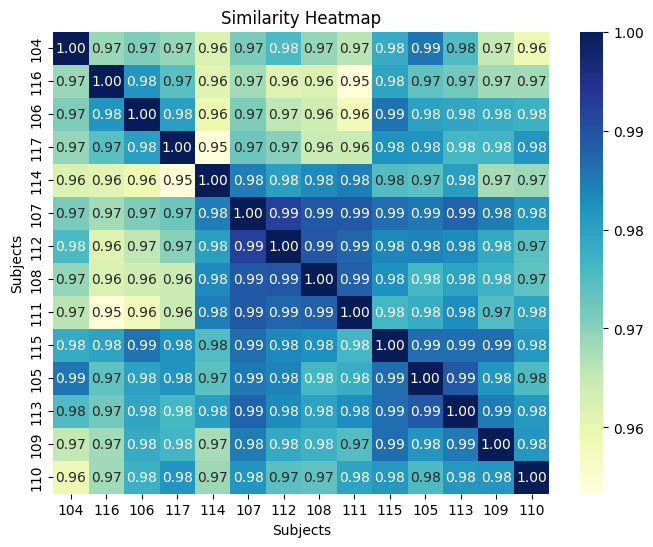

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity

vectors = [subject['average-vector'] for subject in data.values()]

# Calculate the cosine similarity matrix
similarity_matrix = cosine_similarity(vectors)

# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(similarity_matrix, method='ward')

# Reorder the subjects based on the clustering
reordered_indices = hierarchy.leaves_list(linkage_matrix)
reordered_subjects = [list(data.keys())[idx] for idx in reordered_indices]
reordered_similarity_matrix = similarity_matrix[reordered_indices, :][:, reordered_indices]

# Plot the heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(reordered_similarity_matrix, xticklabels=reordered_subjects, yticklabels=reordered_subjects,
            cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Similarity Heatmap')
plt.xlabel('Subjects')
plt.ylabel('Subjects')
plt.show()

Another thing we can do is look at the entire vocabulary of the training data set and return the words that are more similar to each subject. This means that we will find words related to a subject regardless if they were used by the subject or not

In [ ]:
for subject, subject_data in data.items():
    average_vector = np.array([subject_data['average-vector']])
    corpus = {word.text: word.vector for word in w2v.vocab if word.has_vector}

    similarity_scores = cosine_similarity(average_vector, list(corpus.values()))
    top_indices = np.argsort(similarity_scores)[0][-10:]
    top_words = [list(corpus.keys())[i] for i in top_indices]

    print(f'{subject}: {top_words}')

104: ['fraying', 'sticking', 'uncomfortable', 'everything', 'forgetting', 'definitely', 'something', 'somethin', 'actually', 'really']
105: ['squishing', 'basically', 'everything', 'uncomfortable', 'definitely', 'somethin', 'something', 'forgetting', 'really', 'actually']
106: ['uncomfortable', 'sometimes', 'basically', 'everything', 'something', 'somethin', 'forgetting', 'definitely', 'really', 'actually']
107: ['stretchable', 'uncomfortable', 'forgetting', 'everything', 'really', 'squishing', 'fraying', 'sticking', 'basically', 'actually']
108: ['something', 'uncomfortable', 'everything', 'really', 'basically', 'stretchable', 'fraying', 'sticking', 'squishing', 'actually']
109: ['noticeable', 'uncomfortable', 'something', 'somethin', 'definitely', 'everything', 'forgetting', 'basically', 'really', 'actually']
110: ['somethin', 'something', 'practically', 'forgetting', 'uncomfortable', 'noticeable', 'sometimes', 'really', 'basically', 'actually']
111: ['usually', 'really', 'uncomforta

To discuss on Friday:

1. What is obvious from the analysis we performed? Can we learn anything from Word2Vector representations?

2. What can we do to improve the results?

3. What are other things we can do with vector representations? This is the core of any natural language processing project. We will look at two in detail next, but we should be thinking of novel and meaningful analyses throughout:

  - Sentiment analysis: how can we use vector representations to extract sentiment from the document?
  - Topic modeling: how can we use vector representations to identify meaningful topics in the document?

The next step will be to improve on Word2Vec. For that:

1. What are some limitations and assumptions of Word2Vec that influence its results?

2. How can we address those limitations? In other words, if we could create an improved version of Word2Vec, what would it do?

